In [1]:
import time
start_time = time.time();

# Importing libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [3]:
import io
data = pd.read_csv(io.BytesIO(uploaded['IMDB Dataset.csv']))

data.isnull().values.any()

data.shape

(50000, 2)

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


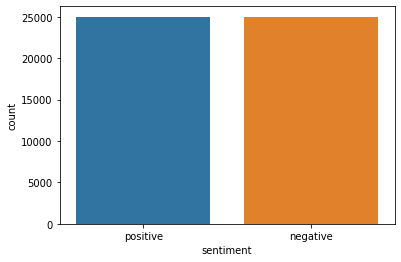

In [ ]:
import seaborn as sns

sns.countplot(x='sentiment', data=data)

In [5]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
    
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [6]:
X = []
sentences = list(data['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [7]:
y = data['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [10]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
from google.colab import files
uploaded = files.upload()

Saving glove.6B.100d.txt to glove.6B.100d.txt


In [23]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [24]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [25]:
from keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [26]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [27]:
history = model.fit(X_train, y_train, batch_size=512, epochs=5, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 18s 548us/step - loss: 0.6154 - acc: 0.6501 - val_loss: 0.5063 - val_acc: 0.7656
Epoch 2/5
32000/32000 [==============================] - 15s 482us/step - loss: 0.5022 - acc: 0.7572 - val_loss: 0.4580 - val_acc: 0.7896
Epoch 3/5
32000/32000 [==============================] - 15s 461us/step - loss: 0.4679 - acc: 0.7775 - val_loss: 0.4472 - val_acc: 0.7961
Epoch 4/5
32000/32000 [==============================] - 15s 477us/step - loss: 0.4354 - acc: 0.7950 - val_loss: 0.4416 - val_acc: 0.7921
Epoch 5/5
10000/10000 [==============================] - 6s 602us/step


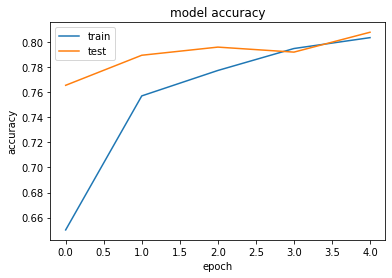

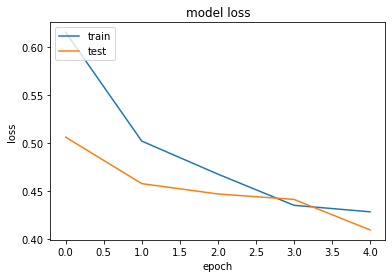

Test Score: 41.58%
Test Accuracy: 80.64%

Execution Time 10848.28819823265 seconds: 


In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

print("Test Score: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))
print(); print("Execution Time %s seconds: " % (time.time() - start_time))

In [41]:
import random
num = random.randint(0,25000)

instance = X[num]
print("Review Index: %d" % (num))
print(instance)
print()
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

result = model.predict(instance)

if result < 0.5:
  print('Negative')
else:
  print('Positive')

Review Index: 288
Yes call this perfect movie Not one boring second fantastic cast of mostly little known actresses and actors great array of characters who are all well defined and who all have understandable motives could sympathize with perfect lighting crisp black and white photography fitting soundtrack an intelligent and harmonious set design and story that is engaging and works It one of those prime quality pictures on which all the pride of Hollywood should rest the mark everyone should endeavor to reach Barbara Stanwyck is simply stunning There was nothing this actress couldn do and she always went easy on the melodramatic side No hysterical outbursts with this lady always thought she was better actress than screen goddesses like Bette Davis or Joan Crawford and this movie confirmed my opinion Always as tough as nails and at the same time conveying true sentiments It is fair to add that she also got many good parts during her long career and this one is by far the least intere

print("Enter a movie review: ")

instance = input()
print()
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

result = model.predict(instance)

if result < 0.5:
  print('Negative')
else:
  print('Positive')